In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from datetime import datetime

# Configurações de exibição do pandas para não truncar o conteúdo
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("Bibliotecas importadas e configurações aplicadas!")

Bibliotecas importadas e configurações aplicadas!


In [2]:
file_path_order = 'Order_semicolon.csv'
file_path_campaign_queue = 'CampaignQueue_semicolon.csv'
file_path_campaign = 'Campaign_semicolon.csv'

# Carregar os arquivos CSV em DataFrames
try:
    df_order = pd.read_csv(file_path_order, sep=';')
    df_campaign_queue = pd.read_csv(file_path_campaign_queue, sep=';')
    df_campaign = pd.read_csv(file_path_campaign, sep=';')

    print("Arquivos carregados com sucesso!")
    print(f"df_order: {df_order.shape[0]} linhas, {df_order.shape[1]} colunas")
    print(f"df_campaign_queue: {df_campaign_queue.shape[0]} linhas, {df_campaign_queue.shape[1]} colunas")
    print(f"df_campaign: {df_campaign.shape[0]} linhas, {df_campaign.shape[1]} colunas")

except FileNotFoundError:
    print("Erro: Um ou mais arquivos não foram encontrados. Por favor, verifique os caminhos dos arquivos.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar os arquivos: {e}")


Arquivos carregados com sucesso!
df_order: 2000 linhas, 23 colunas
df_campaign_queue: 5000 linhas, 16 colunas
df_campaign: 2000 linhas, 14 colunas


In [3]:
print("--- Visualização Inicial: df_order ---")
print("\nPrimeiras 5 linhas:")
print(df_order.head())

print("\nInformações sobre as colunas e tipos de dados:")
df_order.info()

print("\nEstatísticas descritivas básicas:")
print(df_order.describe(include='all'))

--- Visualização Inicial: df_order ---

Primeiras 5 linhas:
   id   companyId containerId         createdAt  customer displayId engineId   engineName engineType                                     extraInfo  integrated  integrationId  isTest orderTiming orderType salesChannel       scheduledAt      status  preparationTime  takeOutTimeInSeconds  totalAmount         updatedAt version
0   1  I0VP1DZXGU    AKVXT2FH  08/01/2025 15:47       525    O8CC98   E3R037  DirectOrder        POS  Adipisci maiores nam eius vero nesciunt sed.        True           2452   False   IMMEDIATE  DELIVERY      ANOTAAI               NaN  DISPATCHED               45                  2131        90.91  09/01/2025 03:32  v3.7.8
1   2  04MEUULZ6W    KKMY5TG5  03/11/2024 22:30       694    HJ99VA   EJVOBV  DirectOrder        APP                                           NaN       False           4688    True   IMMEDIATE  DELIVERY     WHATSAPP               NaN   CONCLUDED               33                   374     

In [4]:
print("--- Visualização Inicial: df_campaign_queue ---")
print("\nPrimeiras 5 linhas:")
print(df_campaign_queue.head())

print("\nInformações sobre as colunas e tipos de dados:")
df_campaign_queue.info()

print("\nEstatísticas descritivas básicas:")
print(df_campaign_queue.describe(include='all'))

--- Visualização Inicial: df_campaign_queue ---

Primeiras 5 linhas:
   id  jobId  campaignId     storeId storeInstanceId  customerId            phoneNumber        scheduledAt            sendAt  status                                            message                                           response         createdAt       createdBy         updatedAt        updatedBy
0   1      1        1553  HJY9QRBZU0        AXHOTYUA         540   5.521.962.375.590,00   23/01/2025 20:26  23/01/2025 22:23       5  Adipisci placeat libero consectetur temporibus...                                                NaN  23/01/2025 09:33          rsilva  24/01/2025 12:41        mirella55
1   2      2        1890  8NQNTXHLZ7        QG7JQPEB         702   5.551.963.199.134,00   25/04/2025 01:48  25/04/2025 02:52       4  Reiciendis quaerat labore exercitationem exped...  Sit illo ullam fugit quisquam quas delectus id...  25/04/2025 01:04  lopesana-julia  25/04/2025 11:14           zviana
2   3      3       

In [5]:
print("--- Visualização Inicial: df_campaign ---")
print("\nPrimeiras 5 linhas:")
print(df_campaign.head())

print("\nInformações sobre as colunas e tipos de dados:")
df_campaign.info()

print("\nEstatísticas descritivas básicas:")
print(df_campaign.describe(include='all'))

--- Visualização Inicial: df_campaign ---

Primeiras 5 linhas:
   id  segmentId  templateId     storeId                      name                                        description      badge  type  status  isDefault            createdAt              createdBy            updatedAt          updatedBy
0   1          1           1  IWKESVR022       Campanha Saepe WGN5  Excepturi earum quas quos tempora suscipit bea...    winback     2       4      False  2024-03-09 11:20:33              uda-costa  2024-08-23 11:20:33    luiz-henrique58
1   2          2           2  GZSR8RUW2X  Campanha Voluptatem H6QI           Officia a facilis saepe iste illo nobis.    loyalty     2       4      False  2024-07-31 07:01:33              roliveira  2025-03-25 07:01:33           lcardoso
2   3          3           3  F4JD1KSIBS      Campanha Itaque MQPN  Blanditiis ipsam qui odit quas minus rerum pra...        NaN     2       3       True  2024-06-06 05:15:59    maria-luizaoliveira  2025-03-25 05:15:59     

In [6]:
def convert_date_column(df, column_name):
    original_type = df[column_name].dtype
    print(f"Iniciando conversão para a coluna '{column_name}' (Tipo original: {original_type})...")

    # Primeiro, tenta converter para numérico para identificar números de série do Excel
    numeric_dates = pd.to_numeric(df[column_name], errors='coerce')

    # Identifica quais são números de série válidos
    excel_serial_mask = numeric_dates.notna() & (numeric_dates > 1) # Números de série são maiores que 1

    # Converte números de série do Excel para datetime
    # 24 * 60 * 60 * 1000000000 para converter para nanosegundos para o pandas Timedelta
    df.loc[excel_serial_mask, column_name] = pd.to_datetime(numeric_dates[excel_serial_mask], unit='D', origin='1899-12-30')

    # Para os valores que não foram números de série, tenta converter diretamente para datetime
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce', dayfirst=True)

    print(f"Conversão concluída para a coluna '{column_name}'. Novos NaT's: {df[column_name].isna().sum()}")
    return df

# Aplicar a função às colunas de data relevantes em df_order
date_columns_order = ['createdAt', 'updatedAt']

for col in date_columns_order:
    if col in df_order.columns:
        df_order = convert_date_column(df_order, col)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada em df_order.")

# Verificar e converter 'totalAmount' para numérico
if 'totalAmount' in df_order.columns:
    df_order['totalAmount'] = pd.to_numeric(df_order['totalAmount'], errors='coerce')
    print(f"\nColuna 'totalAmount' convertida para numérica. Valores nulos após conversão: {df_order['totalAmount'].isna().sum()}")
else:
    print("\nAviso: Coluna 'totalAmount' não encontrada em df_order. Verifique o nome da coluna de valor dos pedidos.")

print("\nVerificação dos tipos de dados de df_order após o tratamento:")
df_order.info()
print("\nPrimeiras linhas de df_order após o tratamento das datas:")
print(df_order.head())

Iniciando conversão para a coluna 'createdAt' (Tipo original: object)...
Conversão concluída para a coluna 'createdAt'. Novos NaT's: 0
Iniciando conversão para a coluna 'updatedAt' (Tipo original: object)...
Conversão concluída para a coluna 'updatedAt'. Novos NaT's: 0

Coluna 'totalAmount' convertida para numérica. Valores nulos após conversão: 0

Verificação dos tipos de dados de df_order após o tratamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    2000 non-null   int64         
 1   companyId             2000 non-null   object        
 2   containerId           2000 non-null   object        
 3   createdAt             2000 non-null   datetime64[ns]
 4   customer              2000 non-null   int64         
 5   displayId             2000 non-null   object        
 6   engineId   

In [7]:
# Remover linhas com valores nulos em 'createdAt' após a conversão, pois são essenciais para a análise temporal
initial_rows = df_order.shape[0]
df_order.dropna(subset=['createdAt'], inplace=True)
print(f"Linhas removidas devido a valores nulos em 'createdAt': {initial_rows - df_order.shape[0]}")

# Extrair o dia da semana e a hora do dia
df_order['hour_of_day'] = df_order['createdAt'].dt.hour
df_order['day_of_week'] = df_order['createdAt'].dt.day_name()

# Mapear os dias da semana para português para melhor visualização (opcional)
day_mapping = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df_order['day_of_week'] = df_order['day_of_week'].map(day_mapping)

print("\nNovas colunas 'hour_of_day' e 'day_of_week' adicionadas a df_order.")
print("Primeiras linhas de df_order com as novas features:")
print(df_order[['createdAt', 'hour_of_day', 'day_of_week']].head())

Linhas removidas devido a valores nulos em 'createdAt': 0

Novas colunas 'hour_of_day' e 'day_of_week' adicionadas a df_order.
Primeiras linhas de df_order com as novas features:
            createdAt  hour_of_day    day_of_week
0 2025-01-08 15:47:00           15   Quarta-feira
1 2024-11-03 22:30:00           22        Domingo
2 2024-09-09 05:49:00            5  Segunda-feira
3 2025-05-22 06:22:00            6   Quinta-feira
4 2025-02-22 01:23:00            1         Sábado


In [8]:
# Aplicar a função às colunas de data relevantes em df_campaign_queue
date_columns_campaign_queue = ['scheduledAt', 'sendAt', 'createdAt', 'updatedAt']

for col in date_columns_campaign_queue:
    if col in df_campaign_queue.columns:
        df_campaign_queue = convert_date_column(df_campaign_queue, col)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada em df_campaign_queue.")

# Verificação dos tipos de dados de df_campaign_queue após o tratamento
print("\nVerificação dos tipos de dados de df_campaign_queue após o tratamento:")
df_campaign_queue.info()
print("\nPrimeiras linhas de df_campaign_queue após o tratamento das datas:")
print(df_campaign_queue[date_columns_campaign_queue].head())

Iniciando conversão para a coluna 'scheduledAt' (Tipo original: object)...
Conversão concluída para a coluna 'scheduledAt'. Novos NaT's: 0
Iniciando conversão para a coluna 'sendAt' (Tipo original: object)...
Conversão concluída para a coluna 'sendAt'. Novos NaT's: 1712
Iniciando conversão para a coluna 'createdAt' (Tipo original: object)...
Conversão concluída para a coluna 'createdAt'. Novos NaT's: 0
Iniciando conversão para a coluna 'updatedAt' (Tipo original: object)...
Conversão concluída para a coluna 'updatedAt'. Novos NaT's: 0

Verificação dos tipos de dados de df_campaign_queue após o tratamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               5000 non-null   int64         
 1   jobId            5000 non-null   int64         
 2   campaignId       5000 non-null   int64         
 3   storeId   

--- Análise de Picos de Pedidos por Hora do Dia ---

Número de pedidos por hora:
    hour_of_day  order_count
0             0           80
1             1           86
2             2           83
3             3           85
4             4           92
5             5           87
6             6          101
7             7           72
8             8           81
9             9           77
10           10           74
11           11           61
12           12           83
13           13           94
14           14           98
15           15           90
16           16           79
17           17           69
18           18           74
19           19           91
20           20           88
21           21           84
22           22           79
23           23           92

A hora com mais pedidos é a **6h**, com **101 pedidos**.


/tmp/ipython-input-3498672319.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_of_day', y='order_count', data=orders_by_hour, palette='viridis')


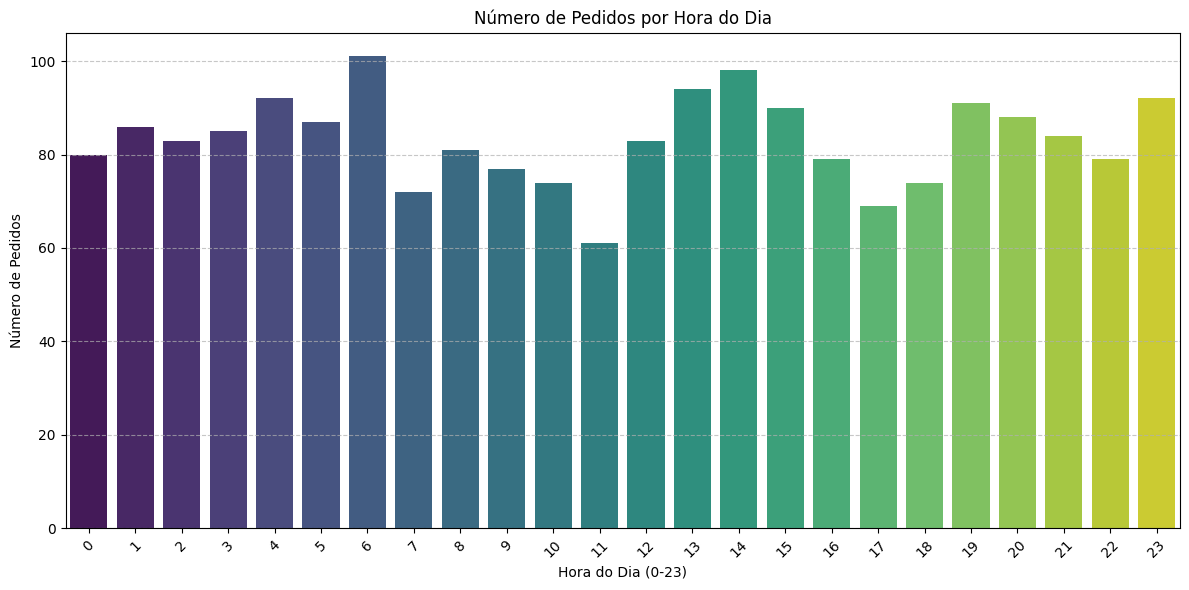

In [9]:
# Contar o número de pedidos por hora do dia
orders_by_hour = df_order.groupby('hour_of_day').size().reset_index(name='order_count')

# Encontrar a hora com o maior número de pedidos
peak_hour_info = orders_by_hour.loc[orders_by_hour['order_count'].idxmax()]
peak_hour = peak_hour_info['hour_of_day']
peak_count = peak_hour_info['order_count']

print("--- Análise de Picos de Pedidos por Hora do Dia ---")
print("\nNúmero de pedidos por hora:")
print(orders_by_hour)

print(f"\nA hora com mais pedidos é a **{int(peak_hour)}h**, com **{int(peak_count)} pedidos**.")

# Visualização dos pedidos por hora do dia
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='order_count', data=orders_by_hour, palette='viridis')
plt.title('Número de Pedidos por Hora do Dia')
plt.xlabel('Hora do Dia (0-23)')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Análise de Picos de Pedidos por Dia da Semana ---

Número de pedidos por dia da semana:
     day_of_week  order_count
0  Segunda-feira          295
1    Terça-feira          297
2   Quarta-feira          287
3   Quinta-feira          265
4    Sexta-feira          272
5         Sábado          273
6        Domingo          311

O dia da semana com mais pedidos é **Domingo**, com **311 pedidos**.


/tmp/ipython-input-1113111387.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='order_count', data=orders_by_day, order=day_order, palette='mako')


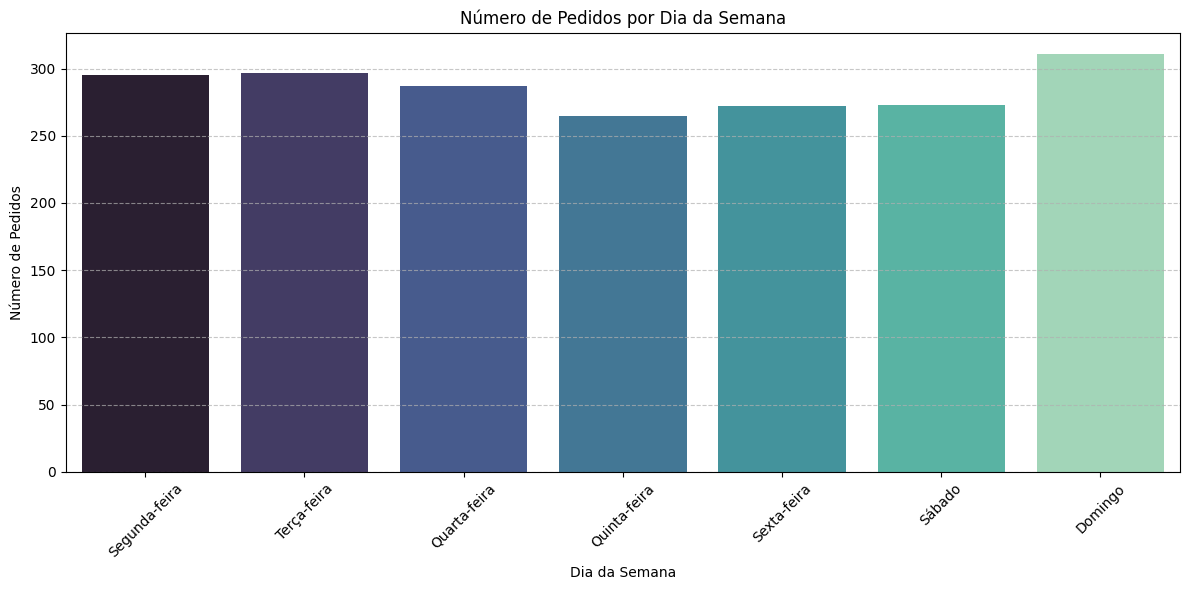

In [10]:
# Definir a ordem dos dias da semana para o gráfico
day_order = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

# Contar o número de pedidos por dia da semana
orders_by_day = df_order.groupby('day_of_week').size().reindex(day_order).reset_index(name='order_count')

# Encontrar o dia com o maior número de pedidos
peak_day_info = orders_by_day.loc[orders_by_day['order_count'].idxmax()]
peak_day = peak_day_info['day_of_week']
peak_day_count = peak_day_info['order_count']

print("--- Análise de Picos de Pedidos por Dia da Semana ---")
print("\nNúmero de pedidos por dia da semana:")
print(orders_by_day)

print(f"\nO dia da semana com mais pedidos é **{peak_day}**, com **{int(peak_day_count)} pedidos**.")

# Visualização dos pedidos por dia da semana
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='order_count', data=orders_by_day, order=day_order, palette='mako')
plt.title('Número de Pedidos por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Análise de Picos de Pedidos por Dia da Semana e Hora do Dia ---

Top 10 dias da semana e horários com mais pedidos:
       day_of_week  hour_of_day  order_count
150    Terça-feira            6           25
135         Sábado           15           21
158    Terça-feira           14           20
78   Segunda-feira            6           20
1          Domingo            1           18
26    Quarta-feira            2           18
148    Terça-feira            4           18
38    Quarta-feira           14           17
92   Segunda-feira           20           17
88   Segunda-feira           16           17


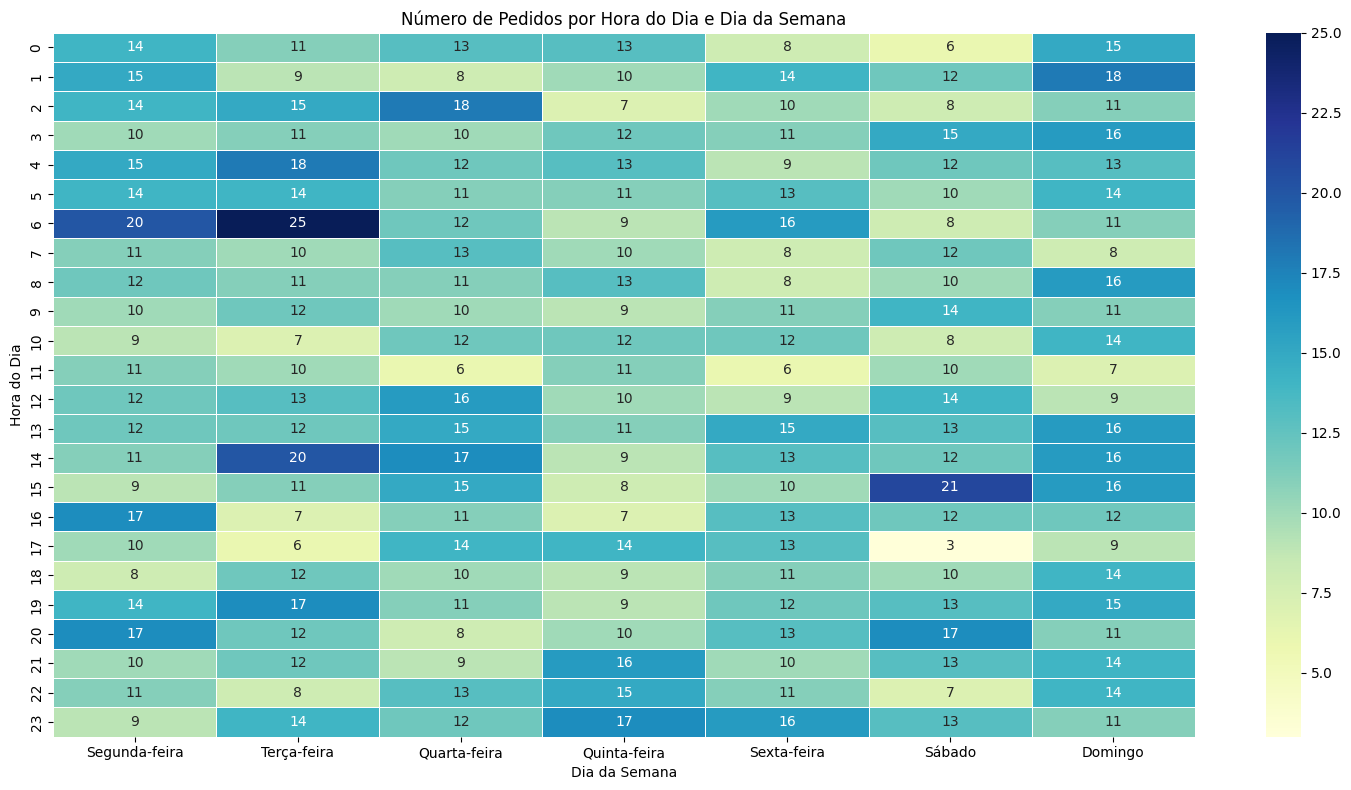

In [11]:
# Contar o número de pedidos por dia da semana e hora do dia
orders_by_day_hour = df_order.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='order_count')

# Ordenar por contagem de pedidos de forma descendente para ver os maiores picos
top_peaks = orders_by_day_hour.sort_values(by='order_count', ascending=False).head(10)

print("--- Análise de Picos de Pedidos por Dia da Semana e Hora do Dia ---")
print("\nTop 10 dias da semana e horários com mais pedidos:")
print(top_peaks)

# Visualização dos pedidos por dia da semana e hora do dia (Heatmap)
plt.figure(figsize=(15, 8))
# Pivotar a tabela para o formato de heatmap
heatmap_data = orders_by_day_hour.pivot_table(index='hour_of_day', columns='day_of_week', values='order_count', fill_value=0)

# Reordenar as colunas (dias da semana) para a ordem correta
heatmap_data = heatmap_data[day_order]

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
plt.title('Número de Pedidos por Hora do Dia e Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.tight_layout()
plt.show()

In [14]:
# Certificar-se de que 'scheduledAt' e 'sendAt' são do tipo datetime
df_campaign_queue['scheduledAt'] = pd.to_datetime(df_campaign_queue['scheduledAt'])
df_campaign_queue['sendAt'] = pd.to_datetime(df_campaign_queue['sendAt'])

# Extrair dia da semana e hora do dia para AGENDAMENTO
df_campaign_queue['scheduled_day_of_week'] = df_campaign_queue['scheduledAt'].dt.day_name()
df_campaign_queue['scheduled_hour_of_day'] = df_campaign_queue['scheduledAt'].dt.hour

# Extrair dia da semana e hora do dia para ENVIO
df_campaign_queue['sent_day_of_week'] = df_campaign_queue['sendAt'].dt.day_name()
df_campaign_queue['sent_hour_of_day'] = df_campaign_queue['sendAt'].dt.hour

# Opcional: Verificar as novas colunas
print("Primeiras linhas de df_campaign_queue com as novas features de data/hora:")
print(df_campaign_queue[['scheduledAt', 'scheduled_day_of_week', 'scheduled_hour_of_day', 'sendAt', 'sent_day_of_week', 'sent_hour_of_day']].head())

Primeiras linhas de df_campaign_queue com as novas features de data/hora:
          scheduledAt scheduled_day_of_week  scheduled_hour_of_day              sendAt sent_day_of_week  sent_hour_of_day
0 2025-01-23 20:26:00              Thursday                     20 2025-01-23 22:23:00         Thursday              22.0
1 2025-04-25 01:48:00                Friday                      1 2025-04-25 02:52:00           Friday               2.0
2 2024-11-04 02:21:00                Monday                      2                 NaT              NaN               NaN
3 2025-07-03 14:30:00              Thursday                     14 2025-07-03 15:30:00         Thursday              15.0
4 2024-09-29 07:36:00                Sunday                      7                 NaT              NaN               NaN


In [15]:
# Contar o número de pedidos para cada combinação de dia da semana e hora do dia
df_demand = df_order.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='order_count')

# Ordenar para facilitar a visualização e categorização
df_demand = df_demand.sort_values(by=['day_of_week', 'hour_of_day']).reset_index(drop=True)
campaign_scheduled_hours = df_campaign_queue.groupby(['scheduled_day_of_week', 'scheduled_hour_of_day']).size().reset_index(name='num_campaigns_scheduled')
campaign_sent_hours = df_campaign_queue.groupby(['sent_day_of_week', 'sent_hour_of_day']).size().reset_index(name='num_campaigns_sent')

# Renomear as colunas para o merge
campaign_scheduled_hours.rename(columns={'scheduled_day_of_week': 'day_of_week', 'scheduled_hour_of_day': 'hour_of_day'}, inplace=True)
campaign_sent_hours.rename(columns={'sent_day_of_week': 'day_of_week', 'sent_hour_of_day': 'hour_of_day'}, inplace=True)

# Merge com df_demand original
df_demand_enriched = df_demand.merge(campaign_scheduled_hours, on=['day_of_week', 'hour_of_day'], how='left')
df_demand_enriched = df_demand_enriched.merge(campaign_sent_hours, on=['day_of_week', 'hour_of_day'], how='left')

# Preencher NaN com 0 onde não houve campanhas naquele slot de tempo
df_demand_enriched['num_campaigns_scheduled'] = df_demand_enriched['num_campaigns_scheduled'].fillna(0).astype(int)
df_demand_enriched['num_campaigns_sent'] = df_demand_enriched['num_campaigns_sent'].fillna(0).astype(int)

# Adicionar flag de fim de semana
df_demand_enriched['is_weekend'] = df_demand_enriched['day_of_week'].isin(['Sábado', 'Domingo']).astype(int)

print("--- Dataset de Demanda Preparado e Enriquecido ---")
print("Primeiras 5 linhas do df_demand_enriched:")
print(df_demand_enriched.head())
print(f"\nTotal de combinações (linhas) de dia/hora: {df_demand_enriched.shape[0]}")
print(f"Estatísticas descritivas da contagem de pedidos:\n{df_demand_enriched['order_count'].describe()}")

peak_threshold = df_demand_enriched['order_count'].mean() + df_demand_enriched['order_count'].std()
print(f"\nLimiar para 'Pico' (Média + 1 Desvio Padrão): {peak_threshold:.2f} pedidos")

def categorize_demand_binary(count):
    if count >= peak_threshold:
        return 'Pico'
    else:
        return 'Normal'

df_demand_enriched['demand_category_binary'] = df_demand_enriched['order_count'].apply(categorize_demand_binary)

print(f"\nCategorias de demanda binárias definidas com base em:")
print(f"  - Pico: >= {peak_threshold:.2f} pedidos")
print(f"  - Normal: < {peak_threshold:.2f} pedidos")
print("\nDistribuição das categorias de demanda binárias:")
print(df_demand_enriched['demand_category_binary'].value_counts())

print("\nPrimeiras 5 linhas do df_demand_enriched com a nova categoria binária:")
print(df_demand_enriched.head())

--- Dataset de Demanda Preparado e Enriquecido ---
Primeiras 5 linhas do df_demand_enriched:
  day_of_week  hour_of_day  order_count  num_campaigns_scheduled  num_campaigns_sent  is_weekend
0     Domingo            0           15                        0                   0           1
1     Domingo            1           18                        0                   0           1
2     Domingo            2           11                        0                   0           1
3     Domingo            3           16                        0                   0           1
4     Domingo            4           13                        0                   0           1

Total de combinações (linhas) de dia/hora: 168
Estatísticas descritivas da contagem de pedidos:
count    168.000000
mean      11.904762
std        3.233874
min        3.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       25.000000
Name: order_count, dtype: float64

Limiar para 'Pico' (Média + 1 Des

In [16]:
# Reordenar os dias da semana para garantir consistência no encoding, se necessário
day_order_for_encoding = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_demand_enriched['day_of_week'] = pd.Categorical(df_demand_enriched['day_of_week'], categories=day_order_for_encoding, ordered=True)

df_encoded_enriched = pd.get_dummies(df_demand_enriched, columns=['day_of_week'], drop_first=False)

print("--- Features Engenheiradas (One-Hot Encoding) ---")
print("Primeiras 5 linhas do DataFrame com features codificadas:")
print(df_encoded_enriched.head())

# --- Definição de X (features) e y (target) ---
# Features (X): 'hour_of_day', 'is_weekend', 'num_campaigns_scheduled', 'num_campaigns_sent' e as colunas One-Hot Encoded dos dias da semana
X = df_encoded_enriched[['hour_of_day', 'is_weekend', 'num_campaigns_scheduled', 'num_campaigns_sent'] + [col for col in df_encoded_enriched.columns if 'day_of_week_' in col]]
y = df_encoded_enriched['demand_category_binary']

print(f"\nFormato de X (features): {X.shape}")
print(f"Formato de y (target): {y.shape}")
print("\nPrimeiras 5 linhas de X:")
print(X.head())
print("\nPrimeiras 5 linhas de y:")
print(y.head())

--- Features Engenheiradas (One-Hot Encoding) ---
Primeiras 5 linhas do DataFrame com features codificadas:
   hour_of_day  order_count  num_campaigns_scheduled  num_campaigns_sent  is_weekend demand_category_binary  day_of_week_Segunda-feira  day_of_week_Terça-feira  day_of_week_Quarta-feira  day_of_week_Quinta-feira  day_of_week_Sexta-feira  day_of_week_Sábado  day_of_week_Domingo
0            0           15                        0                   0           1                 Normal                      False                    False                     False                     False                    False               False                 True
1            1           18                        0                   0           1                   Pico                      False                    False                     False                     False                    False               False                 True
2            2           11                        0      

In [17]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
# Stratify=y para garantir que a proporção de 'Normal' e 'Pico' seja a mesma em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Divisão dos Dados em Treino e Teste ---")
print(f"X_train (treino - features): {X_train.shape}")
print(f"y_train (treino - target): {y_train.shape}")
print(f"X_test (teste - features): {X_test.shape}")
print(f"y_test (teste - target): {y_test.shape}")

print("\nDistribuição das classes em y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição das classes em y_test:")
print(y_test.value_counts(normalize=True))

--- Divisão dos Dados em Treino e Teste ---
X_train (treino - features): (134, 11)
y_train (treino - target): (134,)
X_test (teste - features): (34, 11)
y_test (teste - target): (34,)

Distribuição das classes em y_train:
demand_category_binary
Normal    0.865672
Pico      0.134328
Name: proportion, dtype: float64

Distribuição das classes em y_test:
demand_category_binary
Normal    0.882353
Pico      0.117647
Name: proportion, dtype: float64


--- Treinamento e Avaliação: Árvore de Decisão ---
Resultados com a divisão original de Treino/Teste:

Acurácia da Árvore de Decisão: 0.8529

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.85        34
   macro avg       0.44      0.48      0.46        34
weighted avg       0.78      0.85      0.81        34



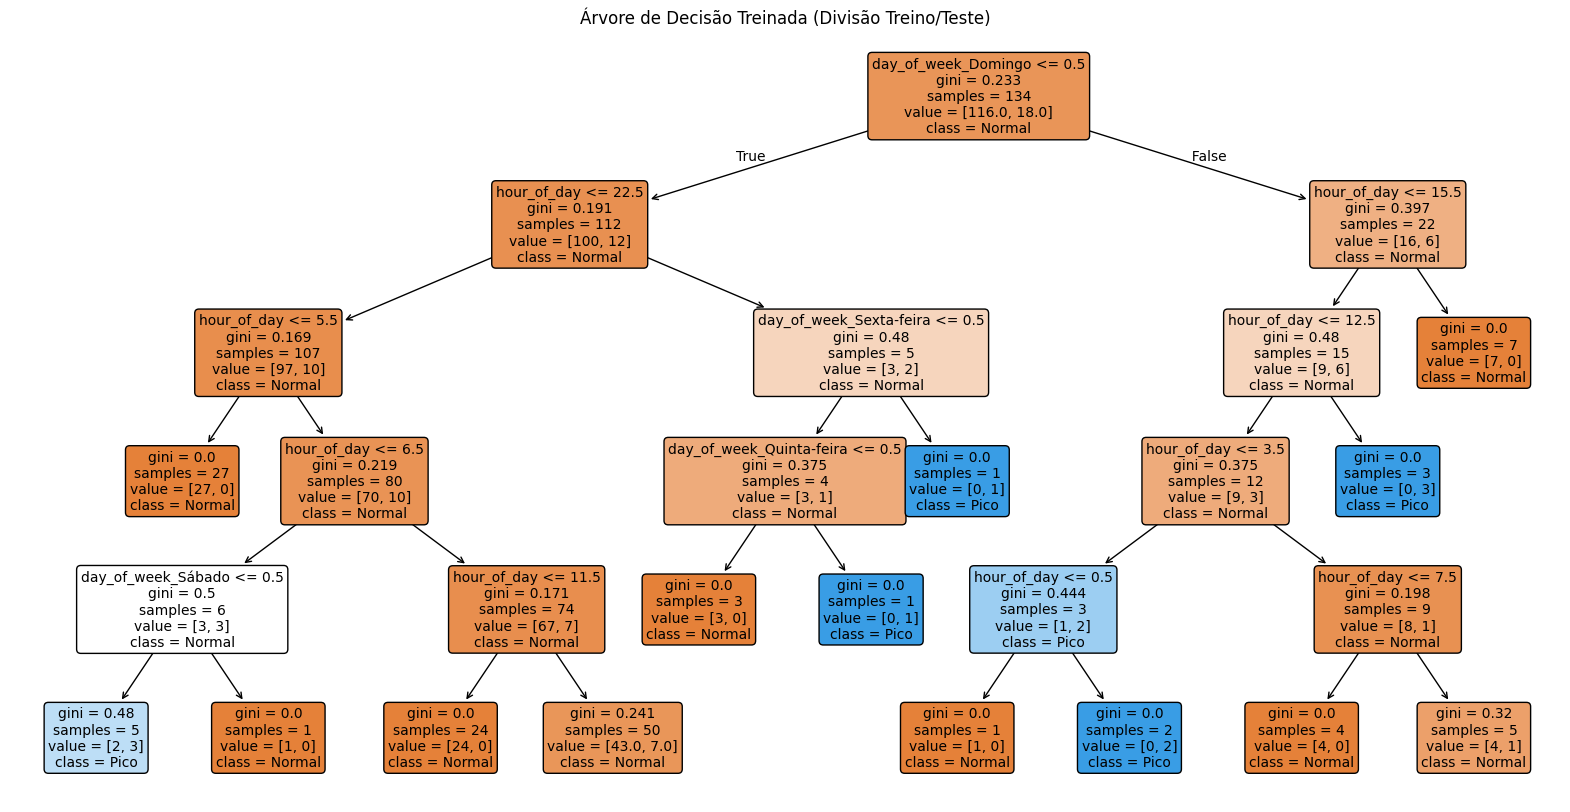

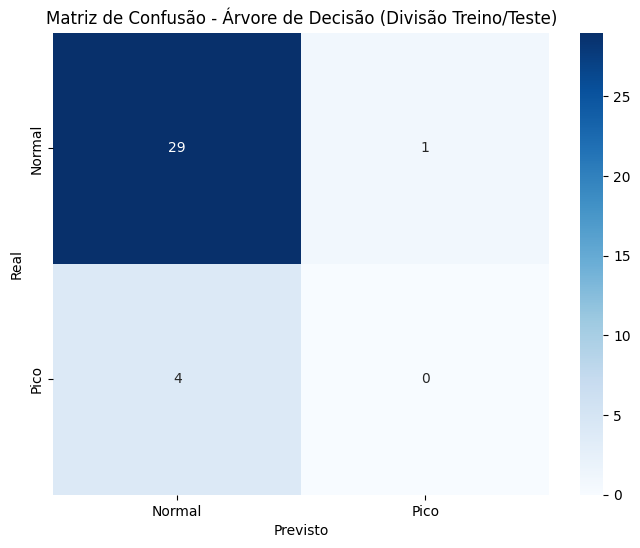


--- Validação Cruzada Stratified K-Fold (Árvore de Decisão) ---

Acurácia Média (CV): 0.8749 (+/- 0.0790)
F1-Score Ponderado Médio (CV): 0.8357 (+/- 0.1086)


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

print("--- Treinamento e Avaliação: Árvore de Decisão ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Inicializar o modelo de Árvore de Decisão
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5)

# Treinar o modelo
dt_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_dt = dt_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Resultados com a divisão original de Treino/Teste:")
print(f"\nAcurácia da Árvore de Decisão: {accuracy_dt:.4f}")
print("\nRelatório de Classificação:")
print(report_dt)

# Visualização da Árvore de Decisão
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=dt_classifier.classes_, filled=True, rounded=True, fontsize=10)
plt.title('Árvore de Decisão Treinada (Divisão Treino/Teste)')
plt.show()

# Matriz de Confusão para Árvore de Decisão
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=dt_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='g', cmap='Blues', xticklabels=dt_classifier.classes_, yticklabels=dt_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de Decisão (Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Árvore de Decisão) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
cv_scores_accuracy = cross_val_score(dt_classifier, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(dt_classifier, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

--- Treinamento e Avaliação: Regressão Logística ---
Resultados com a divisão original de Treino/Teste:

Acurácia da Regressão Logística: 0.8824

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.94        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.88        34
   macro avg       0.44      0.50      0.47        34
weighted avg       0.78      0.88      0.83        34



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


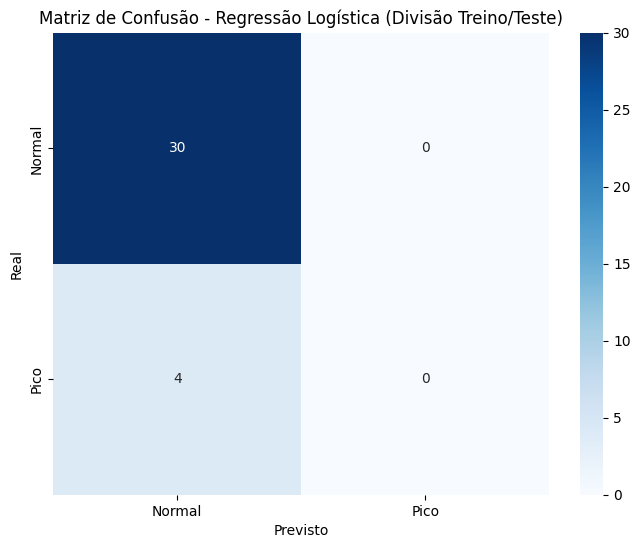


Coeficientes do Modelo de Regressão Logística para cada classe:

--- Coeficientes para a classe 'Pico' (Pico) ---
day_of_week_Domingo          0.464571
is_weekend                   0.035504
hour_of_day                  0.008566
num_campaigns_scheduled      0.000000
num_campaigns_sent           0.000000
day_of_week_Terça-feira     -0.013820
day_of_week_Sexta-feira     -0.272535
day_of_week_Segunda-feira   -0.362102
day_of_week_Quarta-feira    -0.364915
day_of_week_Sábado          -0.429066
day_of_week_Quinta-feira    -0.711929
dtype: float64

--- Coeficientes para a classe 'Normal' (Normal) ---
day_of_week_Quinta-feira     0.711929
day_of_week_Sábado           0.429066
day_of_week_Quarta-feira     0.364915
day_of_week_Segunda-feira    0.362102
day_of_week_Sexta-feira      0.272535
day_of_week_Terça-feira      0.013820
num_campaigns_scheduled     -0.000000
num_campaigns_sent          -0.000000
hour_of_day                 -0.008566
is_weekend                  -0.035504
day_of_week_Doming

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Treinamento e Avaliação: Regressão Logística ---")

lr_classifier = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Treinar o modelo
lr_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_lr = lr_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("Resultados com a divisão original de Treino/Teste:")
print(f"\nAcurácia da Regressão Logística: {accuracy_lr:.4f}")
print("\nRelatório de Classificação:")
print(report_lr)

# Matriz de Confusão para Regressão Logística
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=lr_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', xticklabels=lr_classifier.classes_, yticklabels=lr_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística (Divisão Treino/Teste)')
plt.show()

# Interpretabilidade: Coeficientes do modelo (quanto cada feature influencia)
print("\nCoeficientes do Modelo de Regressão Logística para cada classe:")

# Coeficientes para a classe 'Pico' (geralmente a classe 1)
# O lr_classifier.coef_[0] são os coeficientes que aumentam a probabilidade da classe positiva (Pico)
coefs_pico = pd.Series(lr_classifier.coef_[0], index=X.columns)
print(f"\n--- Coeficientes para a classe '{lr_classifier.classes_[1]}' (Pico) ---")
print(coefs_pico.sort_values(ascending=False))

# Coeficientes para a classe 'Normal' (geralmente a classe 0)
# São o negativo dos coeficientes da classe 'Pico'
coefs_normal = pd.Series(-lr_classifier.coef_[0], index=X.columns)
print(f"\n--- Coeficientes para a classe '{lr_classifier.classes_[0]}' (Normal) ---")
print(coefs_normal.sort_values(ascending=False))


# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Regressão Logística) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
cv_scores_accuracy = cross_val_score(lr_classifier, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(lr_classifier, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")


--- Treinamento e Avaliação: Naive Bayes (GaussianNB) ---
Resultados com a divisão original de Treino/Teste:

Acurácia do Naive Bayes: 0.8235

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      0.93      0.90        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.82        34
   macro avg       0.44      0.47      0.45        34
weighted avg       0.77      0.82      0.80        34



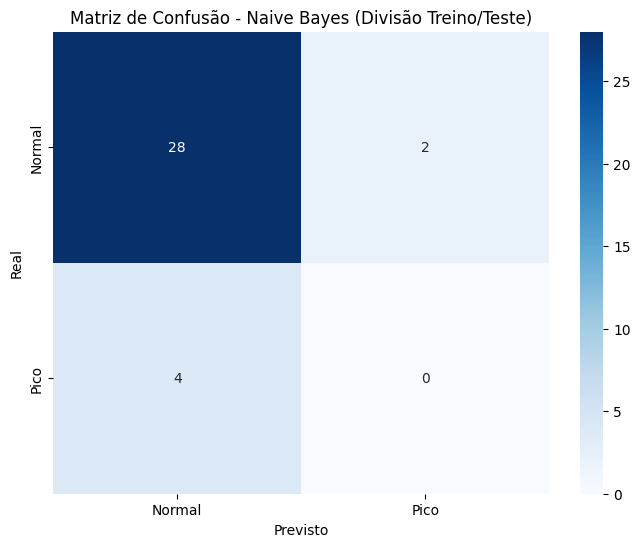


--- Validação Cruzada Stratified K-Fold (Naive Bayes) ---

Acurácia Média (CV): 0.7674 (+/- 0.1040)
F1-Score Ponderado Médio (CV): 0.7797 (+/- 0.1040)


In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Treinamento e Avaliação: Naive Bayes (GaussianNB) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Inicializar o modelo Naive Bayes
gnb_classifier = GaussianNB()

# Treinar o modelo
gnb_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_gnb = gnb_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
report_gnb = classification_report(y_test, y_pred_gnb)

print("Resultados com a divisão original de Treino/Teste:")
print(f"\nAcurácia do Naive Bayes: {accuracy_gnb:.4f}")
print("\nRelatório de Classificação:")
print(report_gnb)

# Matriz de Confusão para Naive Bayes
cm_gnb = confusion_matrix(y_test, y_pred_gnb, labels=gnb_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='g', cmap='Blues', xticklabels=gnb_classifier.classes_, yticklabels=gnb_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Naive Bayes (Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Naive Bayes) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
cv_scores_accuracy = cross_val_score(gnb_classifier, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(gnb_classifier, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

In [24]:
# Criar um flag para "campanha agendada" e "campanha enviada" para cada combinação de (day_of_week, hour_of_day)
campaign_scheduled_hours = df_campaign_queue.groupby(['scheduled_day_of_week', 'scheduled_hour_of_day']).size().reset_index(name='num_campaigns_scheduled')
campaign_sent_hours = df_campaign_queue.groupby(['sent_day_of_week', 'sent_hour_of_day']).size().reset_index(name='num_campaigns_sent')

# Renomear as colunas para o merge
campaign_scheduled_hours.rename(columns={'scheduled_day_of_week': 'day_of_week', 'scheduled_hour_of_day': 'hour_of_day'}, inplace=True)
campaign_sent_hours.rename(columns={'sent_day_of_week': 'day_of_week', 'sent_hour_of_day': 'hour_of_day'}, inplace=True)

# Merge com df_demand original
df_demand_enriched = df_demand.merge(campaign_scheduled_hours, on=['day_of_week', 'hour_of_day'], how='left')
df_demand_enriched = df_demand_enriched.merge(campaign_sent_hours, on=['day_of_week', 'hour_of_day'], how='left')

# Preencher NaN com 0 onde não houve campanhas naquele slot de tempo
df_demand_enriched['num_campaigns_scheduled'] = df_demand_enriched['num_campaigns_scheduled'].fillna(0).astype(int)
df_demand_enriched['num_campaigns_sent'] = df_demand_enriched['num_campaigns_sent'].fillna(0).astype(int)

# Adicionar flag de fim de semana
df_demand_enriched['is_weekend'] = df_demand_enriched['day_of_week'].isin(['Sábado', 'Domingo']).astype(int)

peak_threshold = df_demand_enriched['order_count'].mean() + df_demand_enriched['order_count'].std()
print(f"\nLimiar para 'Pico' (Média + 1 Desvio Padrão): {peak_threshold:.2f} pedidos")

def categorize_demand_binary(count):
    if count >= peak_threshold:
        return 'Pico'
    else:
        return 'Normal'

df_demand_enriched['demand_category_binary'] = df_demand_enriched['order_count'].apply(categorize_demand_binary)

print(f"\nCategorias de demanda binárias definidas com base em:")
print(f"  - Pico: >= {peak_threshold:.2f} pedidos")
print(f"  - Normal: < {peak_threshold:.2f} pedidos")
print("\nDistribuição das categorias de demanda binárias:")
print(df_demand_enriched['demand_category_binary'].value_counts())

print("--- DataFrame de Demanda Enriquecido com Features de Campanhas e Fim de Semana ---")
print("Primeiras 5 linhas do df_demand_enriched:")
print(df_demand_enriched.head())
print("\nInformações sobre as novas colunas:")
print(df_demand_enriched[['num_campaigns_scheduled', 'num_campaigns_sent', 'is_weekend', 'demand_category_binary']].describe())

# --- Re-definição de X (features) e y (target) ---
# Features (X): 'hour_of_day', 'is_weekend' e as colunas One-Hot Encoded dos dias da semana, num_campaigns_scheduled, num_campaigns_sent
df_encoded_enriched = pd.get_dummies(df_demand_enriched, columns=['day_of_week'], drop_first=False)
X_enriched = df_encoded_enriched[['hour_of_day', 'is_weekend', 'num_campaigns_scheduled', 'num_campaigns_sent'] + [col for col in df_encoded_enriched.columns if 'day_of_week_' in col]]
y_enriched = df_encoded_enriched['demand_category_binary']

print(f"\nFormato de X_enriched (features enriquecidas): {X_enriched.shape}")
print(f"Formato de y_enriched (target): {y_enriched.shape}")

# --- Re-divisão dos Dados em Treino e Teste com o dataset enriquecido ---
from sklearn.model_selection import train_test_split
X_train_enriched, X_test_enriched, y_train_enriched, y_test_enriched = train_test_split(X_enriched, y_enriched, test_size=0.2, random_state=42, stratify=y_enriched)

print("\n--- Dados re-divididos em Treino e Teste com features enriquecidas ---")
print(f"X_train_enriched: {X_train_enriched.shape}")
print(f"X_test_enriched: {X_test_enriched.shape}")


Limiar para 'Pico' (Média + 1 Desvio Padrão): 15.14 pedidos

Categorias de demanda binárias definidas com base em:
  - Pico: >= 15.14 pedidos
  - Normal: < 15.14 pedidos

Distribuição das categorias de demanda binárias:
demand_category_binary
Normal    146
Pico       22
Name: count, dtype: int64
--- DataFrame de Demanda Enriquecido com Features de Campanhas e Fim de Semana ---
Primeiras 5 linhas do df_demand_enriched:
  day_of_week  hour_of_day  order_count  num_campaigns_scheduled  num_campaigns_sent  is_weekend demand_category_binary
0     Domingo            0           15                       30                  15           1                 Normal
1     Domingo            1           18                       29                  23           1                   Pico
2     Domingo            2           11                       25                  26           1                 Normal
3     Domingo            3           16                       30                  17           1 

--- Treinamento e Avaliação: Árvore de Decisão (Features Enriquecidas) ---
Resultados com a divisão original de Treino/Teste (Enriquecido):

Acurácia da Árvore de Decisão: 0.8235

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      0.93      0.90        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.82        34
   macro avg       0.44      0.47      0.45        34
weighted avg       0.77      0.82      0.80        34



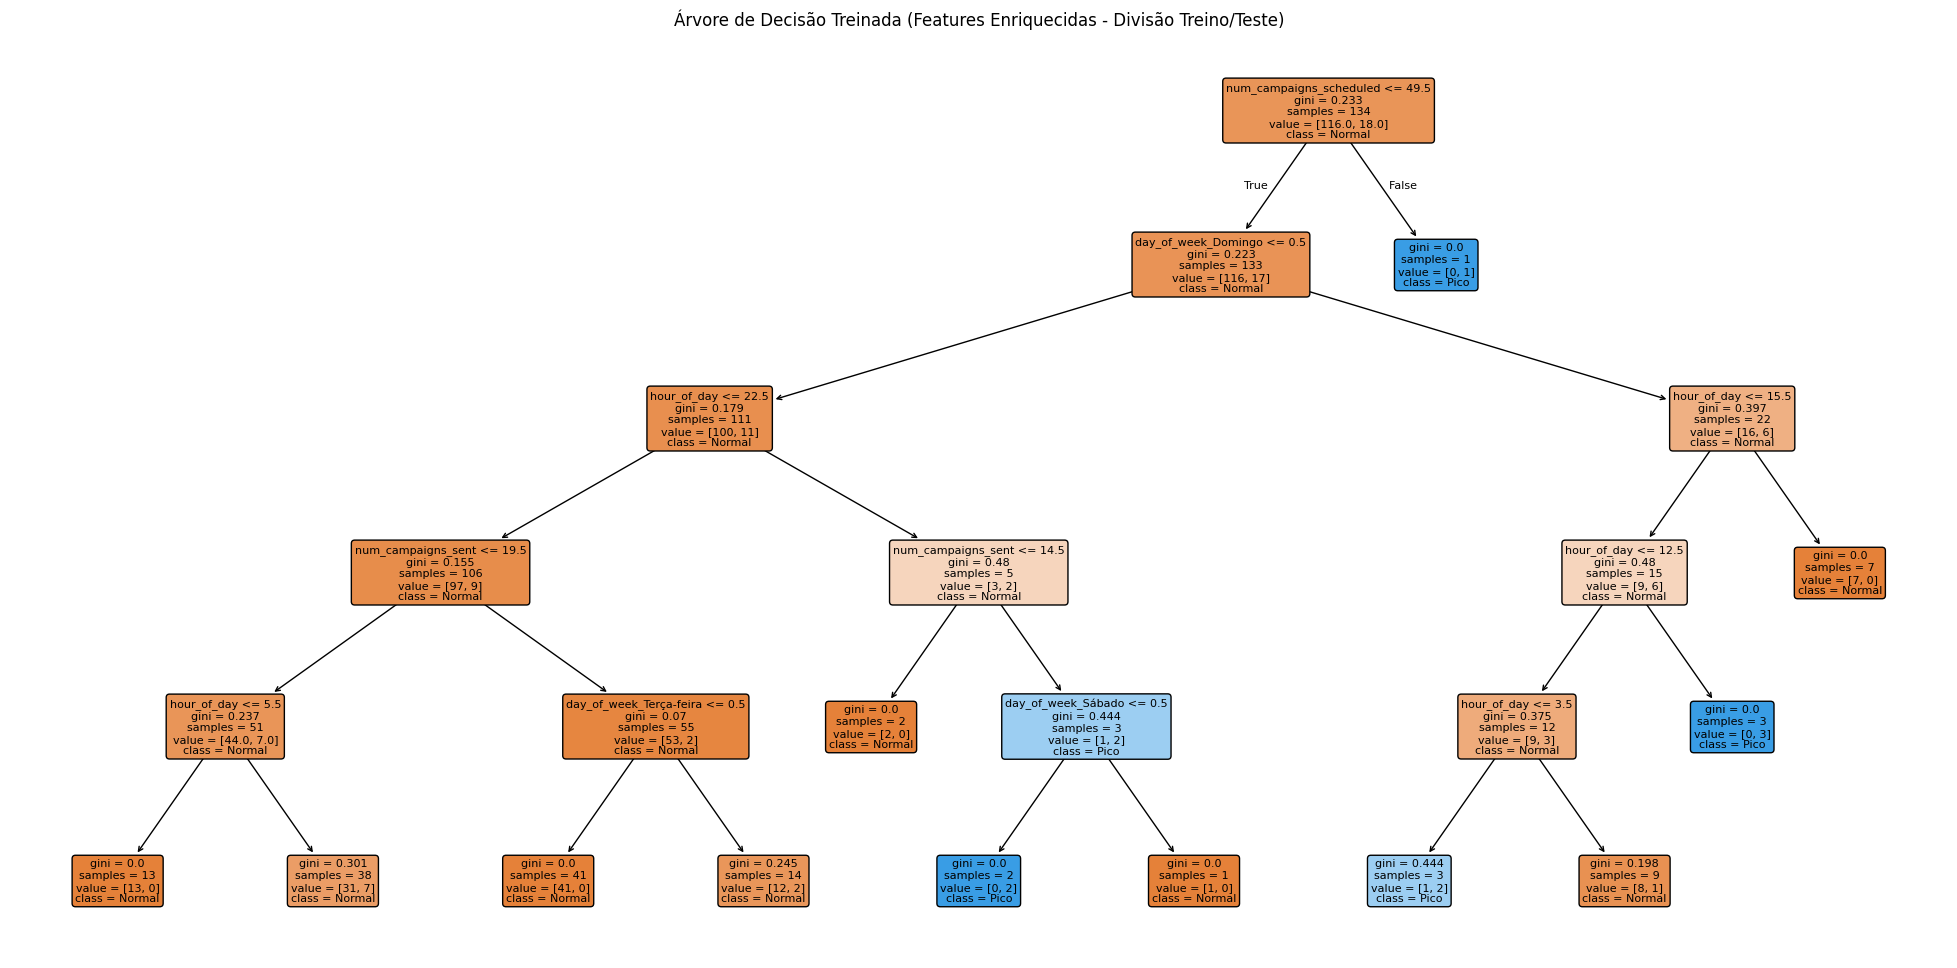

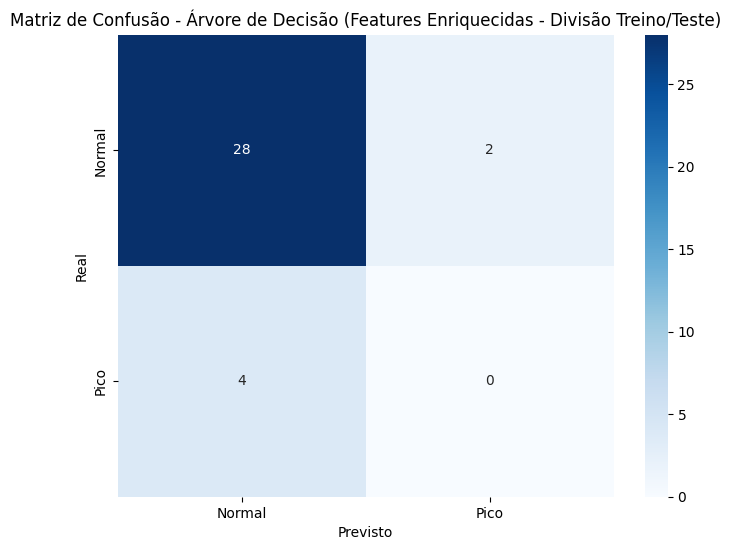


--- Validação Cruzada Stratified K-Fold (Árvore de Decisão - Features Enriquecidas) ---

Acurácia Média (CV): 0.8167 (+/- 0.2192)
F1-Score Ponderado Médio (CV): 0.7845 (+/- 0.1467)


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

print("--- Treinamento e Avaliação: Árvore de Decisão (Features Enriquecidas) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
dt_classifier_enriched = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_classifier_enriched.fit(X_train_enriched, y_train_enriched)
y_pred_dt_enriched = dt_classifier_enriched.predict(X_test_enriched)

accuracy_dt_enriched = accuracy_score(y_test_enriched, y_pred_dt_enriched)
report_dt_enriched = classification_report(y_test_enriched, y_pred_dt_enriched)

print("Resultados com a divisão original de Treino/Teste (Enriquecido):")
print(f"\nAcurácia da Árvore de Decisão: {accuracy_dt_enriched:.4f}")
print("\nRelatório de Classificação:")
print(report_dt_enriched)

# Visualização da Árvore de Decisão (pode ser ainda maior)
plt.figure(figsize=(25, 12)) # Aumentei o tamanho para acomodar mais features
plot_tree(dt_classifier_enriched, feature_names=X_enriched.columns, class_names=dt_classifier_enriched.classes_, filled=True, rounded=True, fontsize=8)
plt.title('Árvore de Decisão Treinada (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

cm_dt_enriched = confusion_matrix(y_test_enriched, y_pred_dt_enriched, labels=dt_classifier_enriched.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_enriched, annot=True, fmt='g', cmap='Blues', xticklabels=dt_classifier_enriched.classes_, yticklabels=dt_classifier_enriched.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de Decisão (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Árvore de Decisão - Features Enriquecidas) ---")
cv_enriched = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
cv_scores_accuracy_dt_enriched = cross_val_score(dt_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='accuracy')
cv_scores_f1_weighted_dt_enriched = cross_val_score(dt_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy_dt_enriched.mean():.4f} (+/- {cv_scores_accuracy_dt_enriched.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted_dt_enriched.mean():.4f} (+/- {cv_scores_f1_weighted_dt_enriched.std() * 2:.4f})")

--- Treinamento e Avaliação: Regressão Logística (Features Enriquecidas) ---
Resultados com a divisão original de Treino/Teste (Enriquecido):

Acurácia da Regressão Logística: 0.8824

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.94        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.88        34
   macro avg       0.44      0.50      0.47        34
weighted avg       0.78      0.88      0.83        34



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


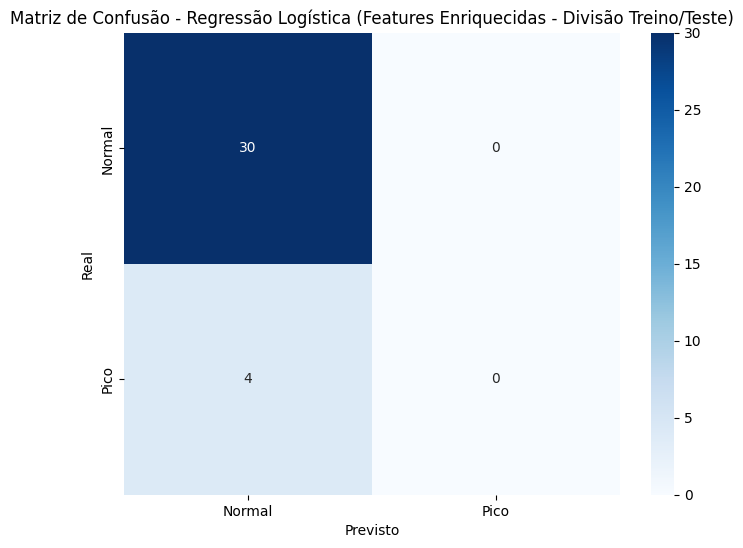


Coeficientes do Modelo de Regressão Logística para cada classe (Features Enriquecidas):

--- Coeficientes para a classe 'Pico' (Pico) ---
day_of_week_Domingo          0.562842
day_of_week_Terça-feira      0.508267
is_weekend                   0.239354
hour_of_day                  0.027169
num_campaigns_scheduled      0.000304
day_of_week_Sexta-feira     -0.042597
num_campaigns_sent          -0.117735
day_of_week_Quarta-feira    -0.185186
day_of_week_Segunda-feira   -0.242747
day_of_week_Sábado          -0.323488
day_of_week_Quinta-feira    -0.407743
dtype: float64

--- Coeficientes para a classe 'Normal' (Normal) ---
day_of_week_Quinta-feira     0.407743
day_of_week_Sábado           0.323488
day_of_week_Segunda-feira    0.242747
day_of_week_Quarta-feira     0.185186
num_campaigns_sent           0.117735
day_of_week_Sexta-feira      0.042597
num_campaigns_scheduled     -0.000304
hour_of_day                 -0.027169
is_weekend                  -0.239354
day_of_week_Terça-feira     -0.5

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Treinamento e Avaliação: Regressão Logística (Features Enriquecidas) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
lr_classifier_enriched = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
lr_classifier_enriched.fit(X_train_enriched, y_train_enriched)
y_pred_lr_enriched = lr_classifier_enriched.predict(X_test_enriched)

accuracy_lr_enriched = accuracy_score(y_test_enriched, y_pred_lr_enriched)
report_lr_enriched = classification_report(y_test_enriched, y_pred_lr_enriched)

print("Resultados com a divisão original de Treino/Teste (Enriquecido):")
print(f"\nAcurácia da Regressão Logística: {accuracy_lr_enriched:.4f}")
print("\nRelatório de Classificação:")
print(report_lr_enriched)

cm_lr_enriched = confusion_matrix(y_test_enriched, y_pred_lr_enriched, labels=lr_classifier_enriched.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_enriched, annot=True, fmt='g', cmap='Blues', xticklabels=lr_classifier_enriched.classes_, yticklabels=lr_classifier_enriched.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

# Interpretabilidade: Coeficientes do modelo
print("\nCoeficientes do Modelo de Regressão Logística para cada classe (Features Enriquecidas):")

coefs_pico = pd.Series(lr_classifier_enriched.coef_[0], index=X_enriched.columns)
print(f"\n--- Coeficientes para a classe '{lr_classifier_enriched.classes_[1]}' (Pico) ---")
print(coefs_pico.sort_values(ascending=False))

# Os coeficientes para a classe 'Normal' (índice 0) são o negativo dos coeficientes da classe 'Pico'.
coefs_normal = pd.Series(-lr_classifier_enriched.coef_[0], index=X_enriched.columns)
print(f"\n--- Coeficientes para a classe '{lr_classifier_enriched.classes_[0]}' (Normal) ---")
print(coefs_normal.sort_values(ascending=False))

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Regressão Logística - Features Enriquecidas) ---")
cv_enriched = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_accuracy_lr_enriched = cross_val_score(lr_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='accuracy')
cv_scores_f1_weighted_lr_enriched = cross_val_score(lr_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy_lr_enriched.mean():.4f} (+/- {cv_scores_accuracy_lr_enriched.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted_lr_enriched.mean():.4f} (+/- {cv_scores_f1_weighted_lr_enriched.std() * 2:.4f})")

--- Treinamento e Avaliação: Naive Bayes (GaussianNB - Features Enriquecidas) ---
Resultados com a divisão original de Treino/Teste (Enriquecido):

Acurácia do Naive Bayes: 0.8529

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.85        34
   macro avg       0.44      0.48      0.46        34
weighted avg       0.78      0.85      0.81        34



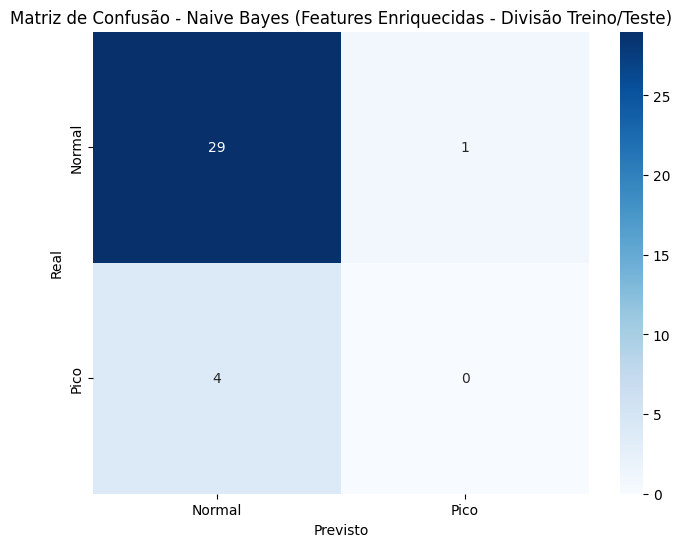


--- Validação Cruzada Stratified K-Fold (Naive Bayes - Features Enriquecidas) ---

Acurácia Média (CV): 0.7738 (+/- 0.0471)
F1-Score Ponderado Médio (CV): 0.7799 (+/- 0.0630)


In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Treinamento e Avaliação: Naive Bayes (GaussianNB - Features Enriquecidas) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
gnb_classifier_enriched = GaussianNB()
gnb_classifier_enriched.fit(X_train_enriched, y_train_enriched)
y_pred_gnb_enriched = gnb_classifier_enriched.predict(X_test_enriched)

accuracy_gnb_enriched = accuracy_score(y_test_enriched, y_pred_gnb_enriched)
report_gnb_enriched = classification_report(y_test_enriched, y_pred_gnb_enriched)

print("Resultados com a divisão original de Treino/Teste (Enriquecido):")
print(f"\nAcurácia do Naive Bayes: {accuracy_gnb_enriched:.4f}")
print("\nRelatório de Classificação:")
print(report_gnb_enriched)

cm_gnb_enriched = confusion_matrix(y_test_enriched, y_pred_gnb_enriched, labels=gnb_classifier_enriched.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb_enriched, annot=True, fmt='g', cmap='Blues', xticklabels=gnb_classifier_enriched.classes_, yticklabels=gnb_classifier_enriched.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Naive Bayes (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Naive Bayes - Features Enriquecidas) ---")
cv_scores_accuracy_gnb_enriched = cross_val_score(gnb_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='accuracy')
cv_scores_f1_weighted_gnb_enriched = cross_val_score(gnb_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy_gnb_enriched.mean():.4f} (+/- {cv_scores_accuracy_gnb_enriched.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted_gnb_enriched.mean():.4f} (+/- {cv_scores_f1_weighted_gnb_enriched.std() * 2:.4f})")

--- Treinamento e Avaliação: Random Forest Classifier (Balanceado, sem restrição de profundidade) ---
Resultados com a divisão original de Treino/Teste (Balanceado, sem restrição de profundidade):

Acurácia do Random Forest: 0.8529

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.85        34
   macro avg       0.44      0.48      0.46        34
weighted avg       0.78      0.85      0.81        34



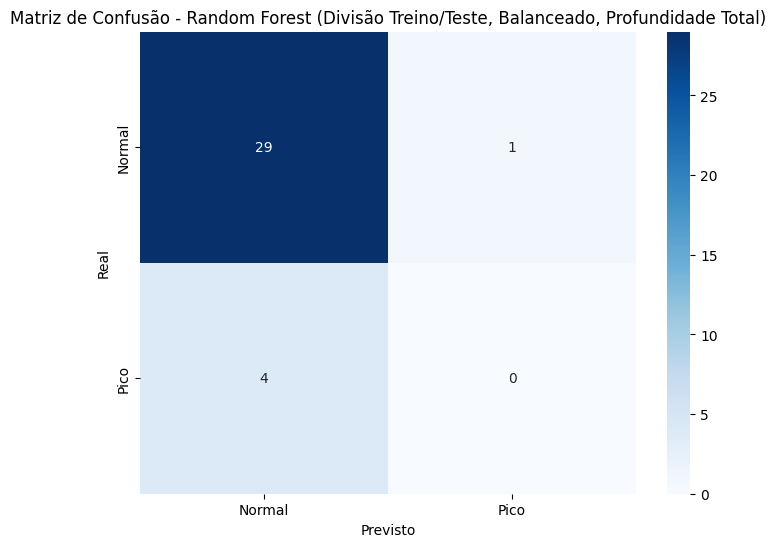


Importância das Features no Random Forest:
hour_of_day                  0.774567
day_of_week_Quinta-feira     0.038337
day_of_week_Domingo          0.036615
day_of_week_Sexta-feira      0.028873
day_of_week_Terça-feira      0.026953
day_of_week_Segunda-feira    0.024830
is_weekend                   0.023849
day_of_week_Sábado           0.023141
day_of_week_Quarta-feira     0.022835
num_campaigns_scheduled      0.000000
num_campaigns_sent           0.000000
dtype: float64

--- Validação Cruzada Stratified K-Fold (Random Forest, Balanceado, sem restrição de profundidade) ---

Acurácia Média (CV): 0.8037 (+/- 0.0786)
F1-Score Ponderado Médio (CV): 0.7887 (+/- 0.0700)


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Treinamento e Avaliação: Random Forest Classifier (Balanceado, sem restrição de profundidade) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Adicionado class_weight='balanced' e removido max_depth para permitir maior complexidade
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # max_depth=None por padrão

# Treinar o modelo
rf_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_rf = rf_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, zero_division=0)

print("Resultados com a divisão original de Treino/Teste (Balanceado, sem restrição de profundidade):")
print(f"\nAcurácia do Random Forest: {accuracy_rf:.4f}")
print("\nRelatório de Classificação:")
print(report_rf)

# Matriz de Confusão para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest (Divisão Treino/Teste, Balanceado, Profundidade Total)')
plt.show()

# Importância das Features (para interpretabilidade)
print("\nImportância das Features no Random Forest:")
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Random Forest, Balanceado, sem restrição de profundidade) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
rf_classifier_cv = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

cv_scores_accuracy = cross_val_score(rf_classifier_cv, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(rf_classifier_cv, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

--- Previsão de Probabilidades e Análise de Threshold ---
Resultados do Conjunto de Teste com Probabilidades de 'Pico':
    Actual_Category  Predicted_Probability_Pico Predicted_Category_RF
2            Normal                        0.75                  Pico
103          Normal                        0.46                Normal
118          Normal                        0.43                Normal
149          Normal                        0.41                Normal
101          Normal                        0.20                Normal
167          Normal                        0.15                Normal
68           Normal                        0.11                Normal
69             Pico                        0.10                Normal
105          Normal                        0.07                Normal
86           Normal                        0.07                Normal

Relatório de Classificação com Threshold Personalizado (0.1):
              precision    recall  f1-score   s

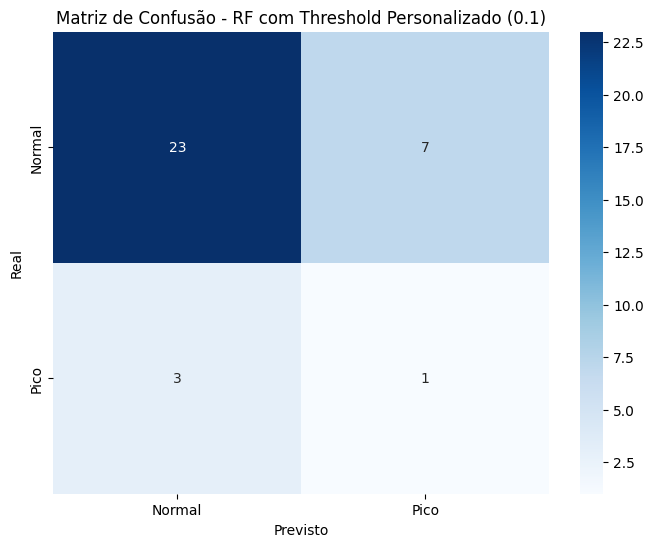


--- Considerações Finais ---
Com o volume atual de dados e a baixa representatividade da classe 'Pico', os modelos têm dificuldade em aprender e generalizar.
A análise de probabilidades, como feito acima, permite uma interpretação mais flexível, onde o limite para considerar um 'Pico' pode ser ajustado com base na tolerância a falsos positivos da operação.
No entanto, a coleta de mais dados ou uma redefinição clara do que constitui um 'Pico' são os caminhos mais promissores para um modelo preditivo mais eficaz.


In [30]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("--- Previsão de Probabilidades e Análise de Threshold ---")

# Obter as probabilidades para cada classe no conjunto de teste
# O predict_proba retorna as probabilidades para todas as classes.
# Precisamos identificar a coluna correspondente à classe 'Pico'.
if 'Pico' in rf_classifier.classes_:
    pico_class_index = list(rf_classifier.classes_).index('Pico')
    probabilities = rf_classifier.predict_proba(X_test)[:, pico_class_index]
else:
    print("A classe 'Pico' não foi encontrada nas classes do modelo. Verifique a categorização.")
    probabilities = np.array([]) # array vazio para evitar erros

# Criar um DataFrame para visualizar as previsões de probabilidade
results_df = pd.DataFrame({
    'Actual_Category': y_test,
    'Predicted_Probability_Pico': probabilities,
    'Predicted_Category_RF': y_pred_rf # Previsão rígida anterior
}, index=X_test.index)

# Exibir os resultados, ordenando pelas maiores probabilidades de 'Pico'
print("Resultados do Conjunto de Teste com Probabilidades de 'Pico':")
print(results_df.sort_values(by='Predicted_Probability_Pico', ascending=False).head(10))

# Análise de um threshold diferente:
# Por exemplo, se quisermos ser mais agressivos e considerar "Pico" se a probabilidade for maior que 0.1
custom_threshold = 0.1
results_df['Predicted_Category_Custom_Threshold'] = np.where(results_df['Predicted_Probability_Pico'] >= custom_threshold, 'Pico', 'Normal')

print(f"\nRelatório de Classificação com Threshold Personalizado ({custom_threshold}):")
print(classification_report(results_df['Actual_Category'], results_df['Predicted_Category_Custom_Threshold'], zero_division=0))

cm_custom_threshold = confusion_matrix(results_df['Actual_Category'], results_df['Predicted_Category_Custom_Threshold'], labels=rf_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom_threshold, annot=True, fmt='g', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - RF com Threshold Personalizado ({custom_threshold})')
plt.show()

print("\n--- Considerações Finais ---")
print("Com o volume atual de dados e a baixa representatividade da classe 'Pico', os modelos têm dificuldade em aprender e generalizar.")
print("A análise de probabilidades, como feito acima, permite uma interpretação mais flexível, onde o limite para considerar um 'Pico' pode ser ajustado com base na tolerância a falsos positivos da operação.")
print("No entanto, a coleta de mais dados ou uma redefinição clara do que constitui um 'Pico' são os caminhos mais promissores para um modelo preditivo mais eficaz.")


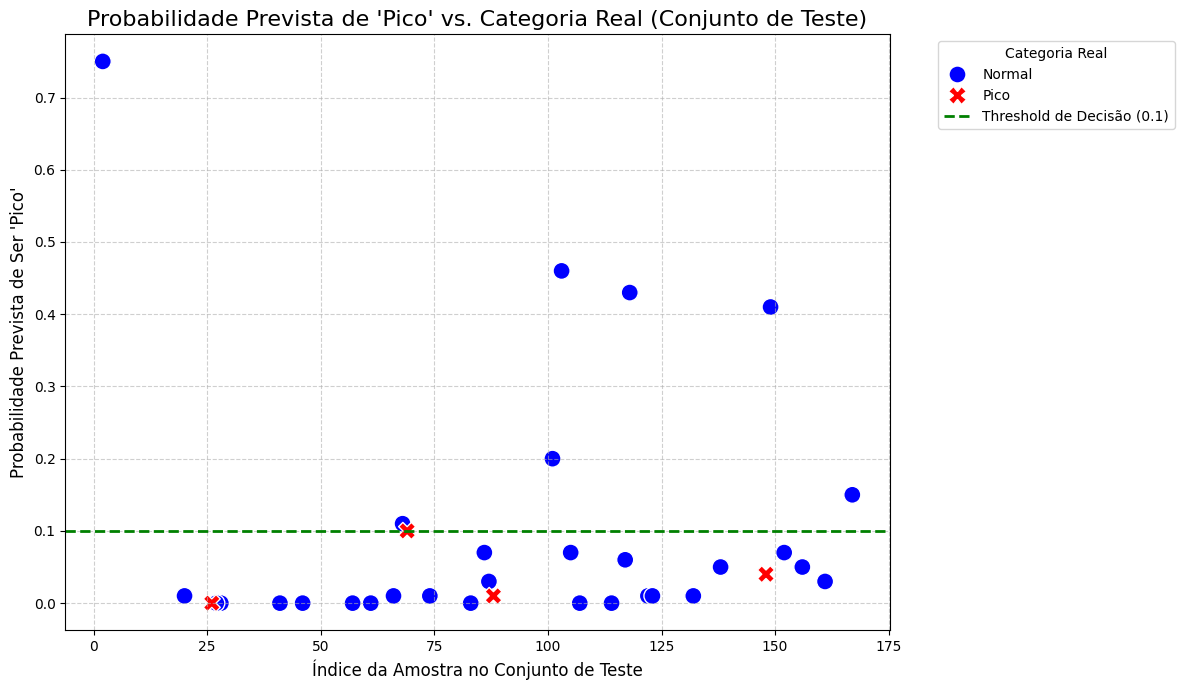

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Import numpy

# Re-gerar y_pred_rf e probabilities caso não estejam mais na memória ativa
if 'rf_classifier' not in locals():
    print("rf_classifier não encontrado. Por favor, execute as células de treinamento do modelo novamente.")
    # Exemplo dummy se rf_classifier não existe, APENAS PARA TESTE. REMOVER EM USO REAL
    # rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    # rf_classifier.fit(X_train, y_train) # Assumindo X_train, y_train existem

y_pred_rf = rf_classifier.predict(X_test)

if 'Pico' in rf_classifier.classes_:
    pico_class_index = list(rf_classifier.classes_).index('Pico')
    probabilities = rf_classifier.predict_proba(X_test)[:, pico_class_index]
else:
    print("A classe 'Pico' não foi encontrada nas classes do modelo.")
    probabilities = np.zeros(len(X_test)) # Array de zeros se 'Pico' não for encontrado

# Criar o DataFrame de resultados novamente
results_df = pd.DataFrame({
    'Actual_Category': y_test,
    'Predicted_Probability_Pico': probabilities,
    'Predicted_Category_RF': y_pred_rf
}, index=X_test.index)

custom_threshold = 0.1 # Nosso threshold definido anteriormente

plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=results_df.index,
    y='Predicted_Probability_Pico',
    hue='Actual_Category',
    style='Actual_Category',
    s=150,
    data=results_df,
    palette={'Normal': 'blue', 'Pico': 'red'}
)

# Adicionar o limiar como uma linha horizontal
plt.axhline(y=custom_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold de Decisão ({custom_threshold})')

plt.title("Probabilidade Prevista de 'Pico' vs. Categoria Real (Conjunto de Teste)", fontsize=16)
plt.xlabel("Índice da Amostra no Conjunto de Teste", fontsize=12)
plt.ylabel("Probabilidade Prevista de Ser 'Pico'", fontsize=12)
plt.legend(title="Categoria Real", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipython-input-173795190.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_campaigns_scheduled', y='order_count', data=campaign_impact_scheduled, palette='viridis')


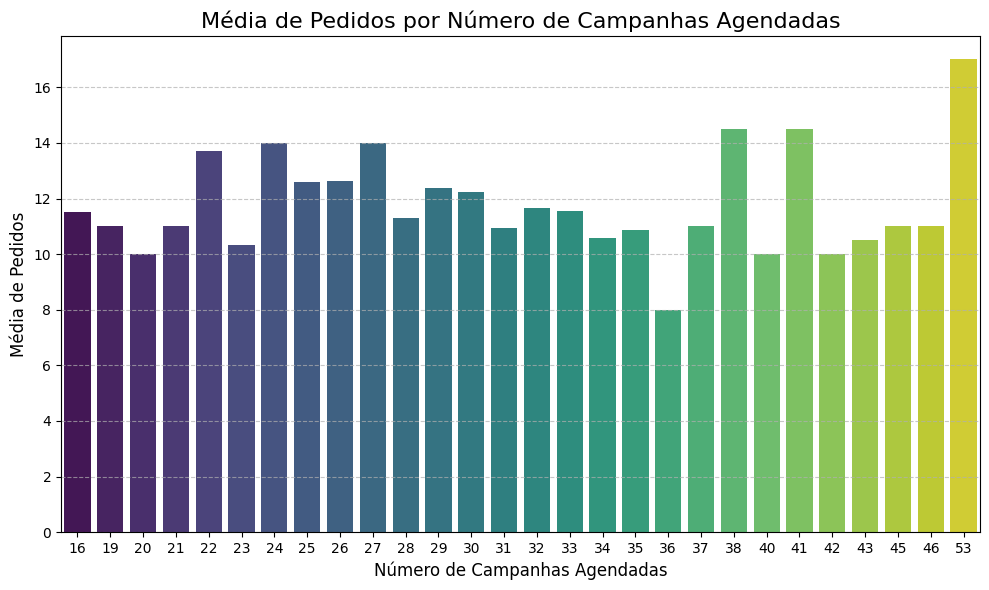

In [34]:
campaign_impact_scheduled = df_demand_enriched.groupby('num_campaigns_scheduled')['order_count'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='num_campaigns_scheduled', y='order_count', data=campaign_impact_scheduled, palette='viridis')
plt.title("Média de Pedidos por Número de Campanhas Agendadas", fontsize=16)
plt.xlabel("Número de Campanhas Agendadas", fontsize=12)
plt.ylabel("Média de Pedidos", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

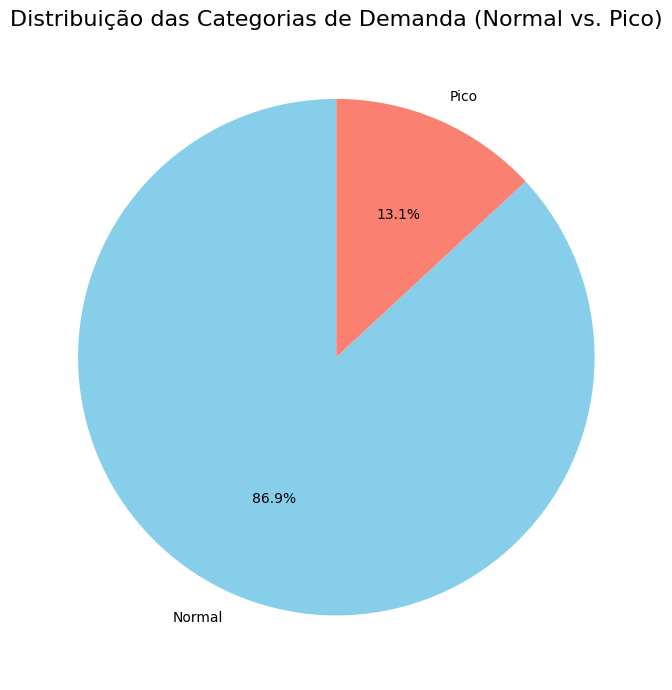

In [35]:
plt.figure(figsize=(7, 7))
df_demand_enriched['demand_category_binary'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title("Distribuição das Categorias de Demanda (Normal vs. Pico)", fontsize=16)
plt.ylabel("")
plt.tight_layout()
plt.show()